# CAO Points Analysis
## Acquiring the data
***

### 2021 [link](http://www.cao.ie/index.php?page=points&p=2021)

In [1]:
# import required libraries
import requests as rq             # Convenient HTTP requests.
import re                         # Regular expressions.
import datetime as dt    
import pandas as pd
import numpy as np

In [2]:
# Make a get request to 2021 CAO points URL
resp = rq.get('http://www2.cao.ie/points/l8.php')

# Check that value = 200 (in which case a connection is made).
resp

<Response [200]>

<br>

**Encoding note:<br>Error on server** <br>
The Server indicated one should decode as per: Content-Type: text/html; charset=iso-8859-1. However, one line of the html uses<br> 
\x96 which isn't defined in iso-8859-1. Therefore the similar decoding standard cp1252 will be  used. This standard is very similar but<br>
includes \x96.

In [3]:
# Specify encoding method 
resp.encoding = 'cp1252'

# Create a file path for the original data.
html_path = 'data/cao_2021_raw_data.html'

# Save original html file
with open(html_path, 'w') as f:
    f.write(resp.text)

In [4]:

def scrape_html_from_website(path, regex):
    
    num_lines = 0                                       # Keep track of courses counted in loop
    with open(path, 'w') as f:                          # Open the csv file for writing.          
        for line in resp.iter_lines():                      # Loop through lines of the response 
            dline = line.decode('cp1252')                       # decode the line 
            if regex.fullmatch(dline):                          # Match only the lines representing courses.       
                num_lines = num_lines + 1                           # Add one to the lines counter if match occured      
                course_code = dline[:5]                             # isolate course code 
                course_title = dline[7:57].strip()                  # isolate course title         
                course_points = re.split(' +', dline[60:])          # split string when on one or more spaces               
                
                if len(course_points) != 2:                   # if list length not equal to 2         
                    course_points = course_points[:2]         # then retain first two elements of list
                   
                linesplit = [course_code, course_title, course_points[0], course_points[1]]
                f.write(','.join(linesplit) + '\n')
    
    print('Total number of lines is lines is {}.\nThis was manually verified against\
"cao_2021_raw_data.html.'.format(num_lines))  
    
# Compile the regular expression for matching lines
    # ([A-Z]{2}[0-9]{3}) matches A-Z x2 characters, 0-9  x3 characters
    # (.*) Matches any single character except newline zero or more times 
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')  

# write parsed data to csv file
write_path = 'data/cao_2021_final_data.csv'         
scrape_html_from_website(write_path, re_course)

Total number of lines is lines is 949.
This was manually verified against"cao_2021_raw_data.html.


### 2020 [link](http://www2.cao.ie/points/CAOPointsCharts2020.xlsx)
***

In [5]:
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'

# request url and write data to disc
resp = rq.get(url2020)                  

# open file for writing in binary mode
output = open('data/cao_2020_raw_data.xlsx', 'wb')    
output.write(resp.content)
output.close() 

In [6]:
def data_handler_2020(url):       
    df = pd.read_excel(url, skiprows = 10)               # read excel & skip first 10 rows (irrelevant)
    df = df.iloc[: , :-8]                                # drop last 8 columns  
    df = df.loc[df.loc[:, 'LEVEL'] == 8]                 # filter df for level 8 courses          
    return df

df_2020 = data_handler_2020(url2020)

# Save dataframe to disk.
write_path = 'data/cao_2020_final_data.csv'
df_2020.to_csv(write_path, encoding = "utf-8")

In [7]:
# Spot check a random row.
print(df_2020.iloc[189])

# Spot check last row.
print(df_2020.iloc[-1])

CATEGORY (i.e.ISCED description)    Engineering and engineering trades
COURSE TITLE                                     Aerospace Engineering
COURSE CODE2                                                     CW568
R1 POINTS                                                          380
R1 Random *                                                        NaN
R2 POINTS                                                          NaN
R2 Random*                                                         NaN
EOS                                                                380
EOS Random *                                                       NaN
EOS Mid-point                                                      442
LEVEL                                                                8
HEI                                    Institute of Technology, Carlow
Test/Interview #                                                   NaN
avp                                                                NaN
v     

### 2019

In [8]:
import urllib3
import pdfplumber
import io


def scrape_pdf_from_website(url):
    http = urllib3.PoolManager()                                   # instansiate pool manager object for sending requests
    temp_binary = io.BytesIO()                                     # create instance for storing binary data
    temp_binary.write(http.request("GET", url).data)               # request url data and write to temp_binary storage
    
    data_final = ''  
    with pdfplumber.open(temp_binary) as pdf:                      # open storage object      
        for page in pdf.pages:                                         # iterate pages of pdf object
            data = page.extract_text()                                 # extract text of page
            data_final += data                                         # concatenates text to data_final variable
    return data_final

url  = 'http://www2.cao.ie/points/lvl8_19.pdf'
pdf_text = scrape_pdf_from_website(url)

In [9]:
def data_handler_2019(regex, line_splitter, text):
    
    df_data = []                                                   # placeholder to add list of rows to
    #print(text)
    #for char in text:                                         # iterate file chars  
    for match in re.finditer(regex, text):                    # iterate matches each line
        course_code = match.group()[0:6]                           # isolate course code
        rest_of_line =  match.group()[6:]                          # isolate all of line after course code 
        rest_of_line = re.split(line_splitter ,rest_of_line)           # split lines using passed criteria
        df_data.append([course_code] + rest_of_line)
                        
    df = pd.DataFrame(df_data)                                # convert array to dataframe
    return df


# regex statement (will isolate all lines starting with course code)
regex = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')
line_split_conditions = '(#\d{3}\* |#\d{2}\* |\d{3}\* |\d{2}\* |\d{3} |\d{2} |#\d{3} |#\d{2} |# \+matric|#)'

df_2019 = data_handler_2019(regex, line_split_conditions, pdf_text)
df_2019.to_csv('data/cao_2019_final.csv')

print('NB: it was verified as of 26/11/2021 that there were {} courses exactly in the CAO 2019 points list.'
      .format(len(df_2019.index)))


NB: it was verified as of 26/11/2021 that there were 930 courses exactly in the CAO 2019 points list.


In [10]:
# Spot check a random row.
print(df_2019.iloc[50])

# Spot chcek last row.
print(df_2019.iloc[-1])

0        CW708 
1    Law - LLB 
2          298 
3           328
Name: 50, dtype: object
0                                       WD230 
1    Mechanical and Manufacturing Engineering 
2                                         273 
3                                          348
Name: 929, dtype: object


<br>

## Joining the data

### Get unique course codes
***

In [11]:
# read in 2021 data from csv and convert to dataframe
df_2021 =  pd.read_csv('data/cao_2021_final_data.csv', encoding ='cp1252', header = None)

In [12]:
# isolate wanted cols from 2020 data and then rename them
df_2020 = df_2020[['COURSE CODE2', 'COURSE TITLE', 'CATEGORY (i.e.ISCED description)', 'HEI', 'R1 POINTS', 'R2 POINTS','R1 Random *', 'R2 Random*', 'Test/Interview #']]
df_2020.columns = ['code', 'title', 'category', 'institution', 'points_r1_2020', 'points_r2_2020', '*r1_2020', '*r2_2020', '#Test/Interview2020']    
df_2021.columns = ['code', 'title', 'points_r1_2021', 'points_r2_2021']  
df_2019.columns = ['code', 'title', 'points_r1_2019', 'points_r2_2019'] 

# remove trailing / leading spaces on code col of all dfs
df_2021['code'] = df_2021['code'].str.strip() 
df_2020['code'] = df_2020['code'].str.strip()
df_2019['code'] = df_2019['code'].str.strip() 

In [13]:
# isolate code and title cols (first two cols) accross all datframes
courses_2019 = df_2019[['code', 'title']]
courses_2020 = df_2020[['code', 'title']]              
courses_2021 = df_2021[['code', 'title']]

In [14]:
# append the three dataframes and sort code alphabetically
all_courses = pd.concat([courses_2021, courses_2020, courses_2019], ignore_index = True)
all_courses.sort_values('code')

print('Shapes:\ncourses_2019 = {}\ncourses_2020 = {}\ncourses_2021 = {}\nall_courses  = {}'
      .format(courses_2019.shape,courses_2020.shape,courses_2021.shape, all_courses.shape))

Shapes:
courses_2019 = (930, 2)
courses_2020 = (1027, 2)
courses_2021 = (949, 2)
all_courses  = (2906, 2)


In [15]:
# return a count on boolean check for all code rows that are duplicates
duplicated_code_rows = all_courses[all_courses.duplicated(subset = ['code'])].count()
duplicated_code_rows

code     1692
title    1692
dtype: int64

In [16]:
# Returns a data frame with duplciates removed (based only on code)
# i.e row count = concat (2906) - duplicated () = unique (2010)
all_courses.drop_duplicates(subset = ['code'], inplace = True, ignore_index = True)
all_courses.shape

(1214, 2)

### Join Points Data
***

In [17]:
# join cols from 3x years while omitting the first two col names (code & title)
# adopted from: https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns

# declarea wanted df and their cols in a list
dfs = [all_courses, 
       df_2019[['code', 'points_r1_2019', 'points_r2_2019']],
       df_2020[['code', 'points_r1_2020', 'points_r2_2020','*r1_2020', '*r2_2020', '#Test/Interview2020']], 
       df_2021[['code', 'points_r1_2021', 'points_r2_2021']]
      ]

In [18]:
# set index val for each df
dfs = [df.set_index('code') for df in dfs]      

# join all dfs after first to the first df
all_courses = dfs[0].join(dfs[1:])

In [27]:
all_courses.head(5)

,institution_letters,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution,category
code,,,,,,,,,,,,,
AC120,AC,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College,Business and administration
AC137,AC,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College,Humanities (except languages)
AD101,AD,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design,Arts
AD102,AD,Graphic Design and Moving Image Design (portfo...,# +matric,635,#+matric,NaN,NaN,NaN,#,#538,NaN,National College of Art and Design,Arts
AD103,AD,Textile and Surface Design and Jewellery and O...,# +matric,545,#+matric,NaN,NaN,NaN,#,#505,NaN,National College of Art and Design,Arts


### Join Institute Data
***

In [20]:
# reset 2021 df index and define its code & institution cols  as new df 
institution_df = df_2020.reset_index()[['code', 'institution']]     

# make new col with code letters, will be used to join institutes
institution_df['institution_letters'] = institution_df['code'].str[:2]   

# drop records that are duplicated (based on institution)
institution_df.drop_duplicates(subset ='institution_letters', keep = "last", inplace = True)

# drop code col
institution_df.drop('code', axis = 1, inplace = True)
institution_df.set_index('institution_letters', inplace = True)

print(institution_df.shape)
institution_df.head(5)

(34, 1)


,institution
institution_letters,
AC,American College
AD,National College of Art and Design
AL,Athlone Institute of Technology
AS,St. Angela`s College
CI,Irish College of Humanities & Applied Sciences


In [21]:
# make temp df to allow concat of missing institutions (this was manually checked on 01 Dec 2021)
# declare new row dict
new_rows = {'institution_letters': ['BN', 'BY', 'DT', 'TA'], 
            'institution': ['Technological University Dublin Blanchardstown Campus',
                            'IBAT College Dublin ',
                            'Technological University Dublin City Campus',
                            'Technological University Dublin Tallaght Campus']}
# convert dict to df
temp_df = pd.DataFrame.from_dict(new_rows).set_index('institution_letters')

# concat  temp df to institution df
institution_df = pd.concat([institution_df, temp_df])

print(institution_df.shape)
institution_df.tail(5)

(38, 1)


,institution
institution_letters,
WD,Waterford Institute of Technology
BN,Technological University Dublin Blanchardstown...
BY,IBAT College Dublin
DT,Technological University Dublin City Campus
TA,Technological University Dublin Tallaght Campus


In [23]:
# Use institution_df as a lookup table to populate institures on main df

# make new col with code letters for all_courses df
all_courses['institution_letters'] = all_courses.index.str[:2]   

# reset index and set institution_letters as new index before joining to institution_df
all_courses = all_courses.reset_index().set_index('institution_letters').join(institution_df['institution'])
all_courses.head(5)

,code,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution
institution_letters,,,,,,,,,,,,
AC,AC120,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College
AC,AC137,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College
AD,AD101,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design
AD,AD102,Graphic Design and Moving Image Design (portfo...,# +matric,635,#+matric,NaN,NaN,NaN,#,#538,NaN,National College of Art and Design
AD,AD103,Textile and Surface Design and Jewellery and O...,# +matric,545,#+matric,NaN,NaN,NaN,#,#505,NaN,National College of Art and Design


### Join Category Data
***

In [24]:
# reset 2021 df index and define its code & institution cols  as new df 
category_df = df_2020[['code', 'category']].set_index('code') 

In [26]:
# Use category df as a lookup table to populate categories on main df
# reset index and set institution_letters as new index before joining to institution_df
all_courses = all_courses.reset_index().set_index('code').join(category_df['category'])
all_courses.head(5)

,institution_letters,title,points_r1_2019,points_r2_2019,points_r1_2020,points_r2_2020,*r1_2020,*r2_2020,#Test/Interview2020,points_r1_2021,points_r2_2021,institution,category
code,,,,,,,,,,,,,
AC120,AC,International Business,234,269,209,NaN,NaN,NaN,NaN,294,294,American College,Business and administration
AC137,AC,Liberal Arts,252,275,252,NaN,NaN,NaN,NaN,271,270,American College,Humanities (except languages)
AD101,AD,First Year Art and Design (Common Entry portfo...,# +matric,550,#+matric,NaN,NaN,NaN,#,#554,NaN,National College of Art and Design,Arts
AD102,AD,Graphic Design and Moving Image Design (portfo...,# +matric,635,#+matric,NaN,NaN,NaN,#,#538,NaN,National College of Art and Design,Arts
AD103,AD,Textile and Surface Design and Jewellery and O...,# +matric,545,#+matric,NaN,NaN,NaN,#,#505,NaN,National College of Art and Design,Arts


<br>

## Reformatting the data
***

As per the CAO Data certain characters / strings are present in the data to give more information. <br>
**'#'**   Test / Interview / Portfolio / Audition <br>
**'*'**   Not everyone was offered places in course <br>

This will now be further explored to deduce what to do with these characters.

In [23]:
# define substring to check cols with '#' and '*' in df

def substring_check(sub_string):
    for col in all_courses:                                                  # iterate df cols                
        count = all_courses[col].str.count(sub_string).sum()                 # sum the count for substring hits
        if count > 0:
            print('Column {} {} count = {}'.format(col, sub_string.replace('\\', ''), count))
            
substring_check(sub_string = '\#')       
print('\n')
substring_check(sub_string = '\*')   

Column points_r1_2021 # count = 81.0
Column points_r2_2021 # count = 17.0
Column points_r1_2020 # count = 22.0
Column points_r2_2020 # count = 2.0
Column #Test/Interview2020 # count = 106.0
Column points_r1_2019 # count = 95.0


Column points_r1_2021 * count = 75.0
Column points_r2_2021 * count = 51.0
Column *r1_2020 * count = 58.0
Column *r2_2020 * count = 29.0
Column points_r1_2019 * count = 44.0
Column points_r2_2019 * count = 1.0


# group # and * together into one col per year

In [24]:
'''
all_courses['*r_2021'] = np.where(all_courses['points_r1_2021'].str.contains('\*'), '*', 
                                  np.where(all_courses['points_r2_2021'].str.contains('\*'), '*', '')  

all_courses['*r_2021'] = np.where(all_courses['points_r1_2021'].str.contains('\*'), '*', 
        
                                  np.where(all_courses['points_r2_2021'].str.contains('\*'), '*', '')  
    
all_courses['Test/Interview #'] = all_courses.where((df['R1 POINTS'].str.contains('#')) | 
                                      (df['R2 POINTS'].str.contains('#')), '#', '')  
'''

"\nall_courses['*r_2021'] = np.where(all_courses['points_r1_2021'].str.contains('\\*'), '*', \n                                  np.where(all_courses['points_r2_2021'].str.contains('\\*'), '*', '')  \n\nall_courses['*r_2021'] = np.where(all_courses['points_r1_2021'].str.contains('\\*'), '*', \n        \n                                  np.where(all_courses['points_r2_2021'].str.contains('\\*'), '*', '')  \n    \nall_courses['Test/Interview #'] = all_courses.where((df['R1 POINTS'].str.contains('#')) | \n                                      (df['R2 POINTS'].str.contains('#')), '#', '')  \n"

In [25]:
#col_str_replace = ['R1 POINTS', 'R2 POINTS', 'MID SEASON POINTS', 'FINAL SEASON POINTS']   
#df[col_str_replace] = np.where(df[col_str_replace] == '#+matric', 'NaN', df[col_str_replace])         # replace '#+matric' with 'NaN' 
#print(all_courses.columns)

In [27]:
cols_for_numeric = ['points_r1_2021', 'points_r2_2021', 'points_r1_2020', 'points_r2_2020', 
                    'points_r1_2019', 'points_r2_2019']

# convert all cols from list to float 64 / int 64, if parsing error then return NaN
#all_courses[cols_for_numeric] = all_courses[cols_for_numeric].apply(pd.to_numeric, errors = 'coerce')

In [29]:
x1 = pd.to_numeric(all_courses['points_r1_2021'], errors='coerce')
x2 = pd.to_numeric(all_courses['points_r2_2021'], errors='coerce')
x3 = pd.to_numeric(all_courses['points_r1_2020'], errors='coerce')
x4 = pd.to_numeric(all_courses['points_r2_2020'], errors='coerce')
x5 = pd.to_numeric(all_courses['points_r1_2019'], errors='coerce')
x6 = pd.to_numeric(all_courses['points_r2_2019'], errors='coerce')

(array([14., 41., 31., 21., 17., 29., 21., 14.,  6.]),
 array([176.        , 225.88888889, 275.77777778, 325.66666667,
        375.55555556, 425.44444444, 475.33333333, 525.22222222,
        575.11111111, 625.        ]),
 <BarContainer object of 9 artists>)

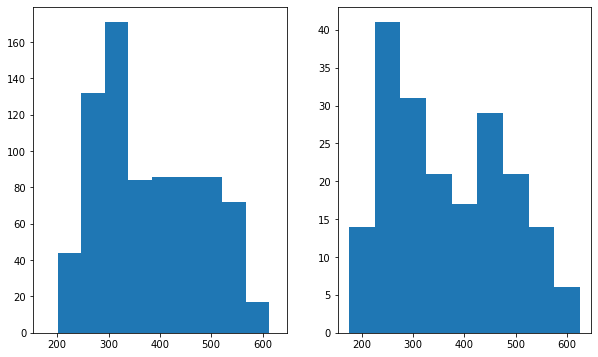

In [30]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharex=True)
ax1.hist(x1, bins = 9)
ax2.hist(x2, bins = 9)


(array([35., 37., 22., 33., 34., 37.,  6.,  2.,  3.]),
 array([184.        , 248.88888889, 313.77777778, 378.66666667,
        443.55555556, 508.44444444, 573.33333333, 638.22222222,
        703.11111111, 768.        ]),
 <BarContainer object of 9 artists>)

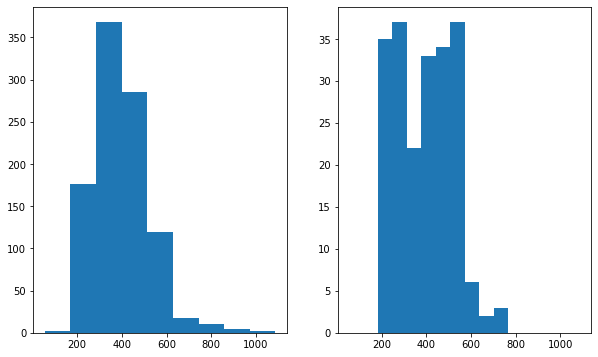

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharex=True)
ax1.hist(x3, bins = 9)
ax2.hist(x4, bins = 9)


(array([  4.,  20., 434., 283., 130.,  10.,   8.,  15.,  12.]),
 array([  57.        ,  169.88888889,  282.77777778,  395.66666667,
         508.55555556,  621.44444444,  734.33333333,  847.22222222,
         960.11111111, 1073.        ]),
 <BarContainer object of 9 artists>)

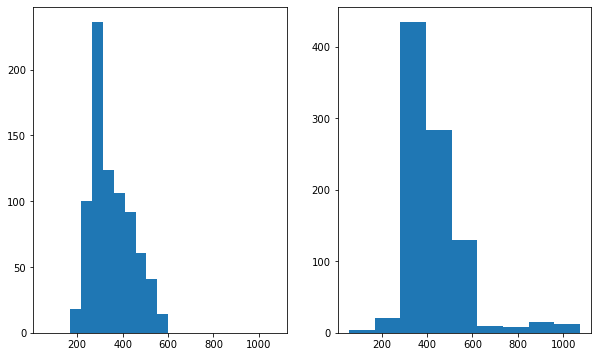

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,6), sharex=True)
ax1.hist(x5, bins = 9)
ax2.hist(x6, bins = 9)
